In [1]:

import pandas as pd
import numpy as np
import random 
from sklearn.preprocessing import LabelEncoder
CSV_PATH="cleaned_songs.csv"
df=pd.read_csv(CSV_PATH)
random_seed=47
df

,author,context,additional_context,song_title,song_text,source
0,Петре М. Андреевски,"Петок е прекрасен ден за читање поезија, па за...",NaN,Наопачно оро,Наопачно оро – Петре М. Андреевски\n\nКој игра...,song_kafe_kniga
1,Кочо Рацин,На 13 јуни 1943 година загинал Кочо Рацин. И п...,NaN,Балада за непознатиот,Балада за непознатиот – Кочо Рацин\n\nНатаму –...,song_kafe_kniga
2,Гане Тодоровски,На 22 мај 2010 година починал еден од најголем...,NaN,Молитва,Молитва – Гане Тодоровски\n\n(пред крајот на г...,song_kafe_kniga
3,Владо Урошевиќ,Денес на блогот читаме прекрасни македонски ст...,NaN,Слобода,Слобода – Влада Урошевиќ\n\nПтица со пет крила...,song_kafe_kniga
4,Кочо Рацин,"Денес е 1 Мај, Меѓународен ден на трудот. Во т...",NaN,Копачите,Копачите – Кочо Рацин\n\nСе к’ти ноќта црна!\n...,song_kafe_kniga
...,...,...,...,...,...,...
1194,Ристо Лазаров,NaN,Аргетинци,ЕВИТА,ЕВИТА \n \nветриштата од западните пампаси \...,СРЕДЕ
1195,Ристо Лазаров,NaN,Аргетинци,ГАРДЕЛ,ГАРДЕЛ \n \nа зина уста \nа птици ќе си ги рас...,СРЕДЕ
1196,Ристо Лазаров,NaN,Аргетинци,БОРХЕС,БОРХЕС \n \nза жал светот с# уште е стварен \...,СРЕДЕ
1197,Ристо Лазаров,NaN,Аргетинци,САБАТО,САБАТО \n \nво сантос лагоресу законите на фи...,СРЕДЕ


Using device: cpu
Found 37 authors
Generating MACEDONIZER embeddings …


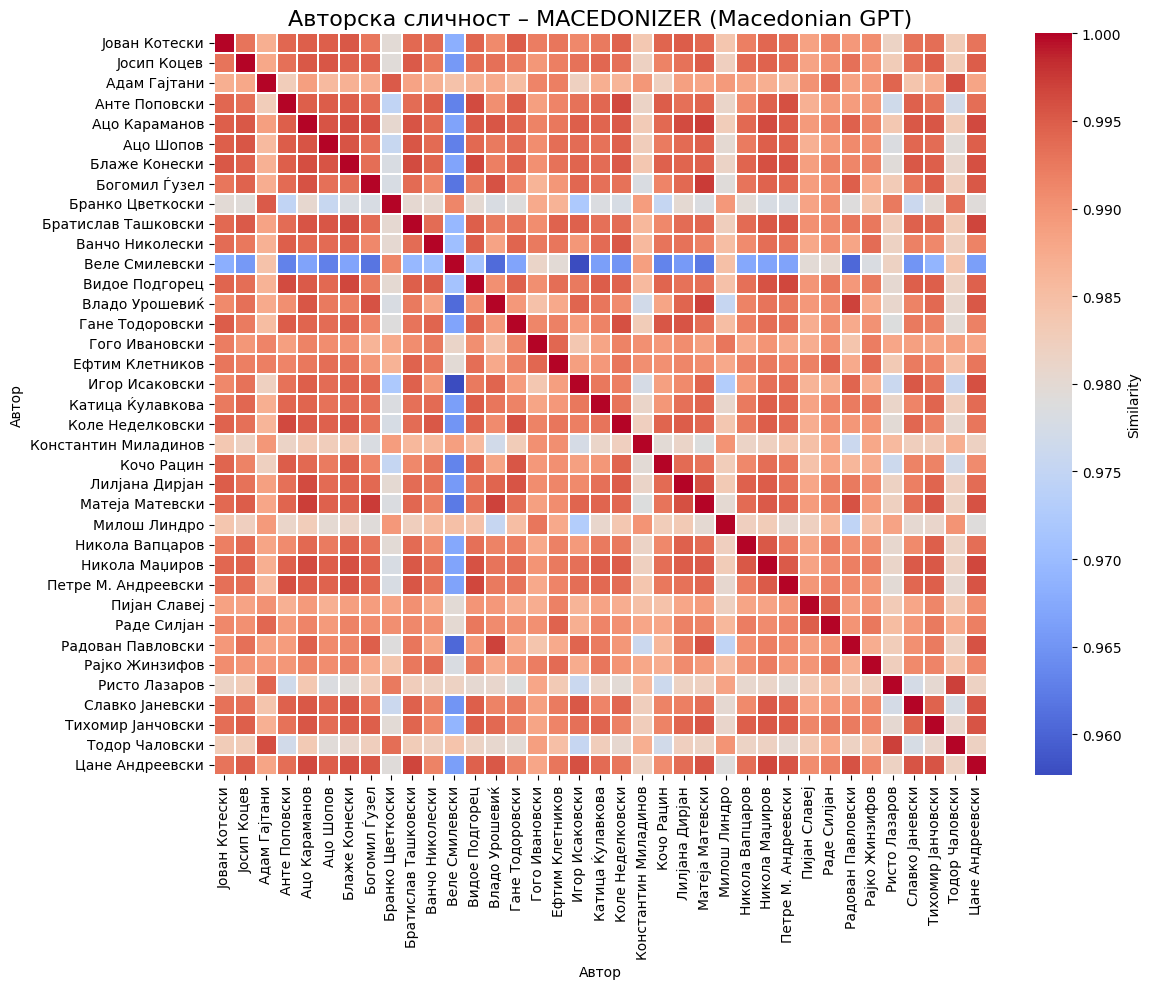


Топ 5 слични автори за **Јован Котески**:
  • Блаже Конески: 0.995
  • Гане Тодоровски: 0.995
  • Лилјана Дирјан: 0.995
  • Ацо Шопов: 0.995
  • Ацо Караманов: 0.995

Топ 5 слични автори за **Јосип Коцев**:
  • Ацо Шопов: 0.996
  • Ацо Караманов: 0.995
  • Братислав Ташковски: 0.995
  • Цане Андреевски: 0.995
  • Матеја Матевски: 0.995

Топ 5 слични автори за **Адам Гајтани**:
  • Тодор Чаловски: 0.996
  • Бранко Цветкоски: 0.995
  • Ристо Лазаров: 0.994
  • Раде Силјан: 0.994
  • Ефтим Клетников: 0.992

Топ 5 слични автори за **Анте Поповски**:
  • Коле Неделковски: 0.996
  • Видое Подгорец: 0.996
  • Петре М. Андреевски: 0.996
  • Ацо Шопов: 0.995
  • Кочо Рацин: 0.995

Топ 5 слични автори за **Ацо Караманов**:
  • Матеја Матевски: 0.997
  • Цане Андреевски: 0.996
  • Никола Маџиров: 0.996
  • Лилјана Дирјан: 0.996
  • Блаже Конески: 0.996

Топ 5 слични автори за **Ацо Шопов**:
  • Ацо Караманов: 0.996
  • Блаже Конески: 0.996
  • Братислав Ташковски: 0.996
  • Јосип Коцев: 0.996
  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# --------------------------------------------------------------
# 1. Load MACEDONIZER (Macedonian GPT-2)
# --------------------------------------------------------------
MODEL_NAME = "macedonizer/sl-gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Force pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cpu")
print(f"Using device: {device}")
model.to(device)
model.eval()

# --------------------------------------------------------------
# 2. EMBEDDING FUNCTION – BULLETPROOF
# --------------------------------------------------------------
def get_gpt_embeddings(texts, batch_size=4, max_len=512):
    all_emb = []
    eos_id = tokenizer.eos_token_id
    vocab_size = tokenizer.vocab_size

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        # Tokenize
        enc = tokenizer(
            batch,
            truncation=True,
            max_length=max_len,
            padding='max_length',        # <-- FORCE FIXED LENGTH
            return_tensors="pt"
        )

        input_ids = enc["input_ids"]
        attention_mask = enc["attention_mask"]

        # CRITICAL: CLAMP ALL IDs TO VALID RANGE
        input_ids = torch.clamp(input_ids, min=0, max=vocab_size - 1)

        # Move to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden = outputs.last_hidden_state  # (B, L, D)

            # Mean pooling
            mask = attention_mask.unsqueeze(-1).float()
            masked = hidden * mask
            summed = masked.sum(1)
            lengths = mask.sum(1).clamp(min=1.0)
            mean_pooled = summed / lengths
            all_emb.append(mean_pooled.cpu().numpy())

    return np.vstack(all_emb)

# --------------------------------------------------------------
# 3. Build author corpus (DO NOT TOUCH df)
# --------------------------------------------------------------
author_corpus = (
    df.groupby("author")["song_text"]
      .apply(lambda x: " ".join(x))
      .reset_index()
)

print(f"Found {len(author_corpus)} authors")

# --------------------------------------------------------------
# 4. Generate embeddings
# --------------------------------------------------------------
print("Generating MACEDONIZER embeddings …")
raw_embeddings = get_gpt_embeddings(
    author_corpus["song_text"].tolist(),
    batch_size=4,
    max_len=512
)

embeddings = normalize(raw_embeddings)

# --------------------------------------------------------------
# 5. Similarity
# --------------------------------------------------------------
sim_matrix = cosine_similarity(embeddings)
sim_df = pd.DataFrame(
    sim_matrix,
    index=author_corpus["author"],
    columns=author_corpus["author"]
)

# --------------------------------------------------------------
# 6. Heatmap
# --------------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(sim_df, cmap="coolwarm", linewidths=0.1, cbar_kws={"label": "Similarity"})
plt.title("Авторска сличност – MACEDONIZER (Macedonian GPT)", fontsize=16)
plt.xlabel("Автор")
plt.ylabel("Автор")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 7. Top 5
# --------------------------------------------------------------
n_similar=37
for author in sim_df.index:
    others = sim_df.loc[author].drop(author)
    top5 = others.sort_values(ascending=False).head(n_similar)
    print(f"\nТоп {n_similar}слични автори за **{author}**:")
    for other, score in top5.items():
        print(f"  • {other}: {score:.3f}")